In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import time as time
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Implement a code to solve the full Hamiltonian

The system is of the form: 
$$
\begin{align}
dq&=pdt \\
dp&= F(q) dt - \gamma p dt + \sqrt{2 \frac{\gamma}{\beta}} dW
\end{align}
$$
with $F(q)= q^2/2$.

### Intuition on the convergence of the BAOAB method
### Step A and B
One can look at the stability property of the BAOAB method applied to the SDE ref sde of interest. 
Step A and B do not have any conditions on $\Delta t$: 
Step A : 
$$
q_{n+1}=q_{n}+p_n \Delta t \\
\rightarrow q_{n+1} = q_0 + \Delta t \sum_i^{n} p_i 
$$
Step B : 
$$
p_{n+1}=p_{n}+F(q_n) \Delta t \\
\rightarrow p_{n+1} = p_0 + \Delta t \sum_i^{n} F(q_i) 
$$
where the conditions on $\Delta t$ regarding stability properties is $\Delta t <1$ and $\Delta t>0$. To see that, we look at equation where $F(x) \approx a+bx$, we use taylor expansion to get an approximation of the function $F$ around the roots. One can plug equation ref at $n$ into equation ref at step $n+1$ and once again equation 1 at steps $n-2$:
$$ 
q_{n+1} = q_0 + \Delta t n p_0 + \Delta t^2 b \left(\frac{n(n-1)}{2} \right) + a \Delta t^2 q_0 \left( \frac{n(n+1)}{2} - (n-2) \right) + a\Delta t^3 \sum_{i=1}^n \sum _{j=1}^{i-1} \sum_{k=1}^{j-1} p_k
$$
where we can see that the term $\Delta t$ appears as a power and therefore the stability condition are $\Delta t<1$.
### Step O
Regarding step 0, we have: 
$$
p_{n+1} = \exp(-\gamma \Delta t) p_n + \sqrt{(1-\exp(-2 \gamma \Delta t)\beta^{-1})} \mathcal{N}(0,1).
$$
We can see that the stability property of the numerical method:   
$$
\mathbb{E} p_{n+1} = \mathbb{E} p_{n} \exp(-\gamma \Delta t) \\
\rightarrow  \mathbb{E} p_{n+1} = \mathbb{E} p_{0} \exp(-\gamma \Delta t n).
$$
For any $\Delta t>0$, $\lim_{n \to \infty}  p_{0} \exp(-\gamma \Delta t n) =0 $. The convergence depends on the size of $\gamma$. If $\gamma$ is higher, the numerical scheme will converge faster. Regarding the variance, we obtain: 
$$
\mathbb{V} [p_{n+1} ]= \mathbb{E} [p_{n+1}^2] - \left( \mathbb{E} [p_{n+1}]\right)^2 \\
\rightarrow  \mathbb{E} [p_{n+1}] = \left(\mathbb{E} [p_{n}^2] - \left( \mathbb{E} [p_{n}]\right)^2\right) \exp(-2 h \gamma n) + \beta^{-2} (1-\exp(-2 \gamma h)) \sum_{i=0}^{n} \exp(-2h \gamma i) \\
\rightarrow  \mathbb{Var} [p_{n+1}] = \mathbb{Var} [p_{n}] \exp(-2 h \gamma n) + \beta^{-2} (1-\exp(-2 \gamma h)) \sum_{i=0}^{n} \exp(-2h \gamma i)
$$
where we can see that the sheme should converge for any values of $\gamma$ and $\beta$ ultimately. However, when the value of $\gamma$ increases, the scheme requires a smaller time steps to achieve the same speed of convergence, while $\beta$ guides the size of the upper bound and a smaller $\beta$ and higher $\beta^{-2}$ means that you are requires to go further in time to reach the invariant distribution. 

The fluctuation term is also sometimes written as $ \sqrt{2 \frac{\gamma}{\beta}} = \sqrt{2 k_B \gamma T}$ so that $T = \frac{1}{\beta}$.

Therefore, a higher temperature requires that we go further in time to reach the same invariant distribution. Let's test those hypothesis


In [1]:
"""
This python file designed a numerical method for SDEs applied to the case of the underdamped langevin dynamic (two dimensional SDE). 
The underdamped system has a potential that is in q^2. 
Because it is two-dimensional, it is necessary to apply an other method than just Euler-Maruyama, so we use the BAOAB method. 
The numerical methods is applied to the transformed SDE using the adaptive function g(x)
The adaptive function is the exponential bounded between dtbounds[0] and dtbounds[1]

This file includes: 
- plot_qp(qp,beta,gamma): a function to plot the true distribution alongside the histogram of the generated sample of p and q 
- F(x): a function of the potential 
- nablaU(x): a function of the potential derivative
- g(x): the adaptive function used here
- A(qp,h): step A of the method
- B(qp,h): step B
- O(qp,h,gamma,beta): step O
- one_traj(qp,T,h,gamma,beta): compute all the steps for the required number of increment to reach T
- method_baoab(n_samples,T,gamma,beta,h): compute the BAOAB method for n_samples 
- one_trajN(qp,gamma,beta,h,Ntimes): compute all the steps for a number Ntimes of increment
- method_baoabN(n_samples,gamma,beta,T,Ntimes): compute the BAOAB method for n_samples for N_times 
"""

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from numba import jit,njit,vectorize, float64, int32
import numba as nb


def F(q):
    return q**2/2


@njit(float64(float64))
def nablaU(q):
    return q

@njit(float64[:](float64[:],float64))
def A(qp,h):
    q=qp[0]
    p=qp[1]
    q = q+p*h
    qp=np.array([q,p])
    return (qp)

@njit(float64[:](float64[:],float64))
def B(qp,h):
    q=qp[0]
    p=qp[1]
    p = p-nablaU(q)*h
    qp=np.array([q,p])
    return (qp)

@njit(float64[:](float64[:],float64,float64,float64))
def O(qp,h,gamma,beta):
    q=qp[0]
    p=qp[1]
    dB = np.random.normal(0,1,1)[0]
    alpha =np.exp(-gamma*h)
    p = alpha*p+ np.sqrt((1-alpha*alpha)/beta)*dB
    qp=np.array([q,p])
    return (qp)

@njit(float64[:](float64[:],float64,float64,float64,float64))
def one_traj(qp,T,h,gamma,beta):
    h_half=h/2
    for i in range(int(T/h)):
        qp=B(qp,h_half)
        qp=A(qp,h_half)
        qp=O(qp,h_half,gamma,beta)
        qp=A(qp,h_half)
        qp=B(qp,h_half)
    return (qp)

@njit(parallel=True)
def method_baoab(N,T,gamma,beta,h):
    qp_list=np.zeros((N,2))
    qipi = np.array([1.0,1.0]) #np.random.normal(0,1,2) #initial conditions
    for j in nb.prange(N):
        qfpf = one_traj(qipi,T,h,gamma,beta)
        qp_list[j,::]=qfpf
    return(qp_list)

@njit(float64[:](float64[:],float64,float64,float64,float64))
def one_trajN(qp,gamma,beta,h,Ntimes):
    h_half=h/2
    for i in range(Ntimes):
        qp=B(qp,h_half)
        qp=A(qp,h_half)
        qp=O(qp,h_half,gamma,beta)
        qp=A(qp,h_half)
        qp=B(qp,h_half)
    return (qp)

@njit(parallel=True)
def method_baoabN(n_samples,gamma,beta,T,Ntimes):
    qp_list=np.zeros((n_samples,2))
    qipi = np.array([1.0,1.0]) #np.random.normal(0,1,2) #initial conditions
    h=np.round(T/Ntimes,6)
    for j in nb.prange(N):
        qfpf = one_trajN(qipi,gamma,beta,h,Ntimes)
        qp_list[j,::]=qfpf
    return(qp_list)

    
# axis of the plot 
def plot_qp(qp,beta,gamma):
    fig, (ax1,ax2,ax3)= plt.subplots(1, 3,figsize=(16,6))# plt.figure(figsize=(4,4))
    fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

    fig.suptitle("$\\beta$="+str(beta)+", $\\gamma=$"+str(gamma)+", $N=$"+str(len(qp[::,0])))

    #Plot 1
    ## position q experiment
    histogram,bins = np.histogram(qp[::,0],bins=100,range=[-3,3], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    ax1.plot(midx,histogram,label='q-Experiment')
    ax1.legend() 

    #Plot 2: 
    ### momentum p experiment
    histogram,bins = np.histogram(qp[::,1],bins=100,range=[-3,3], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    # histogram=(histogram/np.sum(histogram)*(midx[1]-midx[0]) )
    ax2.plot(midx,histogram,label='p-Experiment')


    ### mementum p true
    rho = np.exp(- beta*(midx**2)/2)
    rho = rho / ( np.sum(rho)* (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
    ax2.plot(midx,rho,'--',label='Truth')
    ax1.plot(midx,rho,'--',label='Truth')
    ax2.legend() 

    #Plot 3 
    ax3.set_ylim(-5,5)
    ax3.plot(qp[::,1],label="p")
    ax3.plot(qp[::,0],label="q")

    ax3.legend()



In [6]:
T=10
h = 0.1
gamma = 1
beta=10000
# compile
Ntimes=1
n_samples=1
%time method_baoabN(n_samples,gamma,beta,T,Ntimes)
# run for 1 no compiler 
N=1
%time qp=method_baoab(T,gamma,beta,h,N)


CPU times: user 1.6 s, sys: 7.81 ms, total: 1.61 s
Wall time: 1.45 s
CPU times: user 1.87 s, sys: 0 ns, total: 1.87 s
Wall time: 1.38 s


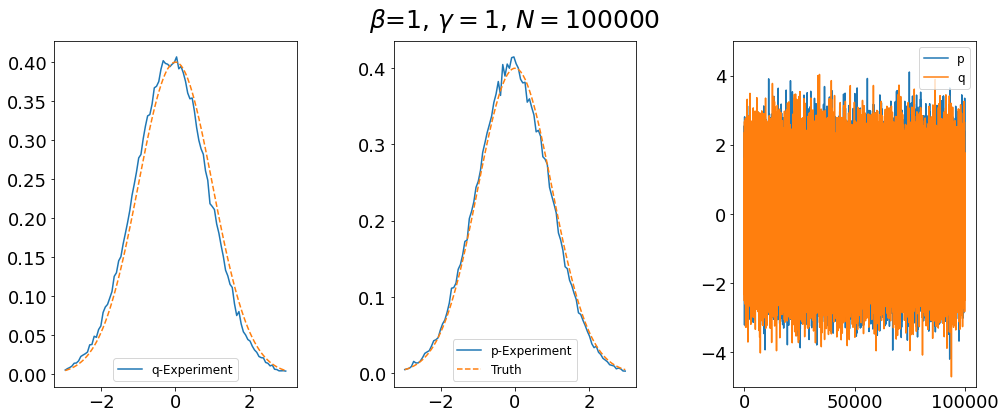

In [8]:
T=10
h = 0.1
gamma = 1
beta=1
N=10**5
qp1=method_baoab(N,T,gamma,beta,h)
plot_qp(qp1,beta,gamma)


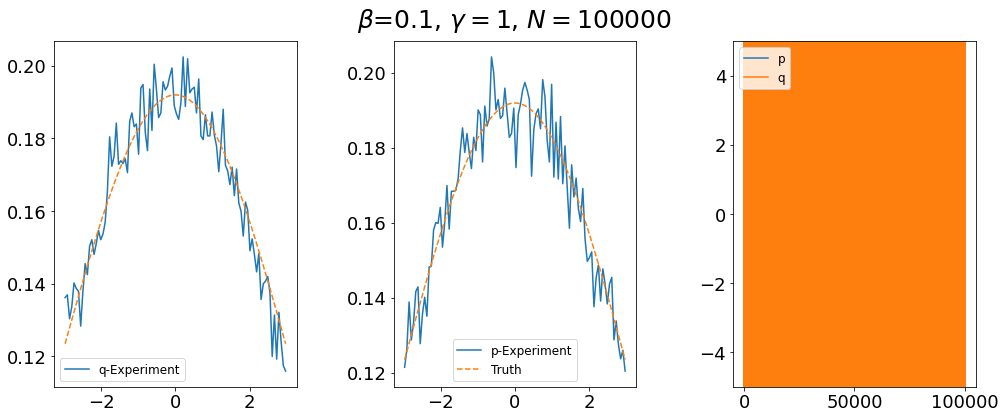

In [9]:
T=10
h = 0.1
gamma = 1
beta=0.1
N=10**5
qp2=method_baoab(N,T,gamma,beta,h)
plot_qp(qp2,beta,gamma)

When $\beta$ get smaller, the noise is higher and the upper bounds on the stability of the numerical method is higher, or you need a smaller time steps to achieve the same accuracy. When $\gamma$ is smaller, the speed of convergence is lower and you need to go further in time to get closer to the invariant distribution ! 

### Intuition on the convergence of the BAOAB method
### Step A and B
One can look at the stability property of the BAOAB method applied to the SDE ref sde of interest. 
Step A and B do not have any conditions on $\Delta t$: 
Step A : 
$$
q_{n+1}=q_{n}+p_n \Delta t \\
\rightarrow q_{n+1} = q_0 + \Delta t \sum_i^{n} p_i 
$$
Step B : 
$$
p_{n+1}=p_{n}+F(q_n) \Delta t \\
\rightarrow p_{n+1} = p_0 + \Delta t \sum_i^{n} F(q_i) 
$$
where the conditions on $\Delta t$ regarding stability properties is $\Delta t <1$ and $\Delta t>0$. To see that, we look at equation where $F(x) \approx a+bx$, we use taylor expansion to get an approximation of the function $F$ around the roots. One can plug equation ref at $n$ into equation ref at step $n+1$ and once again equation 1 at steps $n-2$:
$$ 
q_{n+1} = q_0 + \Delta t n p_0 + \Delta t^2 b \left(\frac{n(n-1)}{2} \right) + a \Delta t^2 q_0 \left( \frac{n(n+1)}{2} - (n-2) \right) + a\Delta t^3 \sum_{i=1}^n \sum _{j=1}^{i-1} \sum_{k=1}^{j-1} p_k
$$
where we can see that the term $\Delta t$ appears as a power and therefore the stability condition are $\Delta t<1$.
### Step O
Regarding step 0, we have: 
$$
p_{n+1} = \exp(-\gamma \Delta t) p_n + \sqrt{(1-\exp(-2 \gamma \Delta t)\beta^{-1})} \mathcal{N}(0,1).
$$
We can see that the stability property of the numerical method:   
$$
\mathbb{E} p_{n+1} = \mathbb{E} p_{n} \exp(-\gamma \Delta t) \\
\rightarrow  \mathbb{E} p_{n+1} = \mathbb{E} p_{0} \exp(-\gamma \Delta t n).
$$
For any $\Delta t>0$, $\lim_{n \to \infty}  p_{0} \exp(-\gamma \Delta t n) =0 $. The convergence depends on the size of $\gamma$. If $\gamma$ is higher, the numerical scheme will converge faster. Regarding the variance, we obtain: 
$$
\mathbb{V} [p_{n+1} ]= \mathbb{E} [p_{n+1}^2] - \left( \mathbb{E} [p_{n+1}]\right)^2 \\
\rightarrow  \mathbb{E} [p_{n+1}] = \left(\mathbb{E} [p_{n}^2] - \left( \mathbb{E} [p_{n}]\right)^2\right) \exp(-2 h \gamma n) + \beta^{-2} (1-\exp(-2 \gamma h)) \sum_{i=0}^{n} \exp(-2h \gamma i) \\
\rightarrow  \mathbb{Var} [p_{n+1}] = \mathbb{Var} [p_{n}] \exp(-2 h \gamma n) + \beta^{-2} (1-\exp(-2 \gamma h)) \sum_{i=0}^{n} \exp(-2h \gamma i)
$$
where we can see that the sheme should converge for any values of $\gamma$ and $\beta$ ultimately. However, when the value of $\gamma$ increases, the scheme requires a smaller time steps to achieve the same speed of convergence, while $\beta$ guides the size of the upper bound and a smaller $\beta$ and higher $\beta^{-2}$ means that you are requires to go further in time to reach the invariant distribution. 


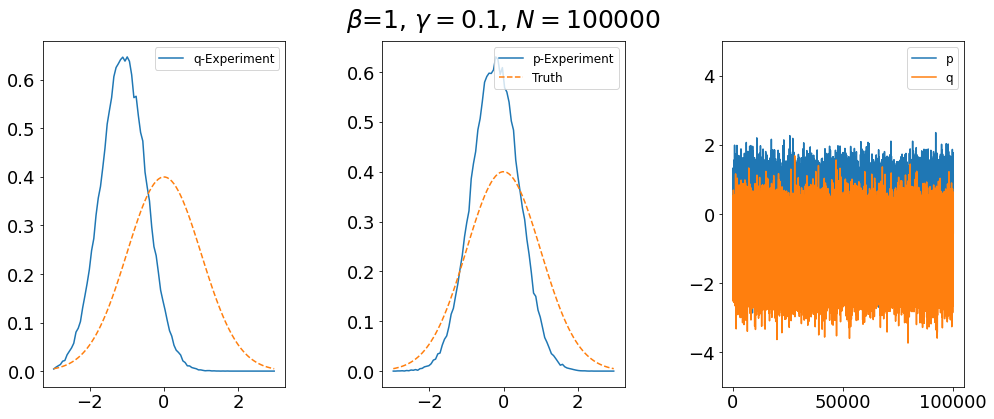

In [10]:
T=10
h = 0.1
gamma = 0.1
beta=1
N=10**5
qp3=method_baoab(N,T,gamma,beta,h)
plot_qp(qp3,beta,gamma)

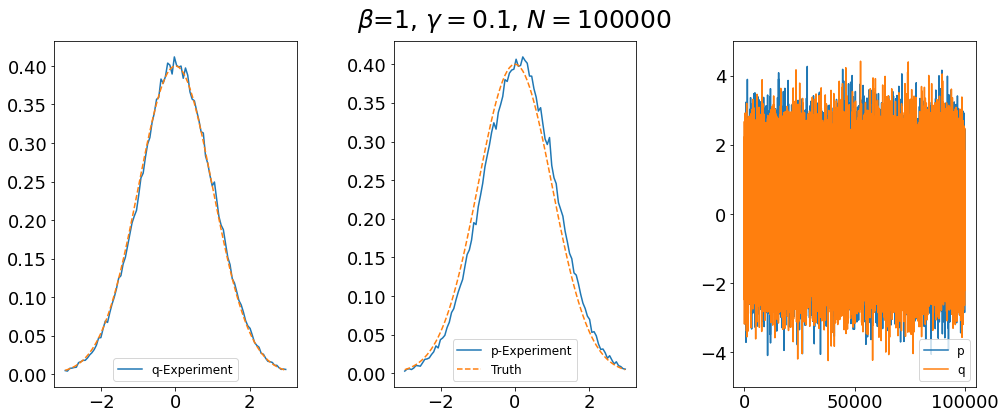

In [11]:
T=100
h = 0.1
gamma = 0.1
beta=1
N=10**5
qp4=method_baoab(N,T,gamma,beta,h)
plot_qp(qp4,beta,gamma)